In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import os
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Activation, Dense, Flatten


# In[2]:


path_train = os.listdir('/kaggle/input/chest-ctscan-images/Data/train')
path_test = os.listdir('/kaggle/input/chest-ctscan-images/Data/test')
path_train_str = '/kaggle/input/chest-ctscan-images/Data/train'
path_test_str = '/kaggle/input/chest-ctscan-images/Data/test'
path_val = os.listdir('/kaggle/input/chest-ctscan-images/Data/valid')
path_val_str = '/kaggle/input/chest-ctscan-images/Data/valid'


# In[3]:


classes_test = ['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma']
classes = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib','large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa','normal','squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
def obtain_data(X,Y,path,istest = 0):
    if istest==1:
        for i in classes_test:
            path_new = os.path.join(path,i)
            for j in os.listdir(path_new):
                img = cv2.imread(os.path.join(path_new,j))
                img = cv2.resize(img,(256,256))
                X.append(img)
                Y.append(i)
    else:
        for i in classes:
            path_new = os.path.join(path,i)
            for j in os.listdir(path_new):
                img = cv2.imread(os.path.join(path_new,j))
                img = cv2.resize(img,(256,256))
                X.append(img)
                Y.append(i)


# In[4]:


X_train = []
Y_train = []
X_test = []
Y_test = []

obtain_data(X_train,Y_train,path_train_str)
obtain_data(X_test,Y_test,path_test_str,1)
obtain_data(X_train,Y_train,path_val_str)

# In[5]:


X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

# In[6]:


X_train,Y_train = shuffle(X_train,Y_train,random_state=101)

y_train_new = []
for i in Y_train:
    y_train_new.append(classes.index(i))
Y_train = y_train_new
Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_new = []
for i in Y_test:
    y_test_new.append(classes_test.index(i))
Y_test = y_test_new
Y_test = tf.keras.utils.to_categorical(Y_test)


# Converging Path :
# 
# Layer 1

# In[7]:


inputs = tf.keras.layers.Input((256,256,3))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1)
p1 = tf.keras.layers.BatchNormalization()(p1)


# Layer 2

# In[8]:


c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.3)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2)
p2 = tf.keras.layers.BatchNormalization()(p2)


# Layer 3

# In[9]:


c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3)
p3 = tf.keras.layers.BatchNormalization()(p3)


# Layer 4

# In[10]:


c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)
p4 = tf.keras.layers.BatchNormalization()(p4)


# Layer 5

# In[11]:


c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01))(c5)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c5)
c6 = tf.keras.layers.Dropout(0.3)(p5)
c6 = tf.keras.layers.Flatten()(c6)
c7 = tf.keras.layers.Dense(256,kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L1(0.001))(c6)
c7 = tf.keras.layers.Dropout(0.2)(c7)
outputs = tf.keras.layers.Dense(4,activation = 'softmax')(c7)


# In[17]:


model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'], sample_weight_mode='temporal')
model.summary()


# Model Checkpoint

# In[18]:


checkpointer = tf.keras.callbacks.ModelCheckpoint('Brain_tumour_model.h5',verbose=1,save_best_only=True)


# Early Stopping

# In[19]:


callbacks = [tf.keras.callbacks.ModelCheckpoint('Brain_tumour_model.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]


# In[ ]:


results = model.fit(X_train,Y_train,validation_split = 0.2,batch_size=8,epochs=300,callbacks=callbacks)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 dropout (Dropout)           (None, 256, 256, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                             

2023-09-03 17:11:32.017062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 16.0319 - accuracy: 0.4380
Epoch 1: val_loss improved from inf to 11.99979, saving model to Brain_tumour_model.h5
69/69 [==============================] - 16s 45ms/step - loss: 16.0319 - accuracy: 0.4380 - val_loss: 11.9998 - val_accuracy: 0.2628
Epoch 2/300
67/69 [============================>.] - ETA: 0s - loss: 10.3518 - accuracy: 0.4515
Epoch 2: val_loss improved from 11.99979 to 9.53228, saving model to Brain_tumour_model.h5
69/69 [==============================] - 2s 28ms/step - loss: 10.3334 - accuracy: 0.4507 - val_loss: 9.5323 - val_accuracy: 0.2482
Epoch 3/300
67/69 [============================>.] - ETA: 0s - loss: 8.5431 - accuracy: 0.5075
Epoch 3: val_loss improved from 9.53228 to 8.61856, saving model to Brain_tumour_model.h5
69/69 [==============================] - 2s 28ms/step - loss: 8.5200 - accuracy: 0.5109 - val_loss: 8.6186 - val_accuracy: 0.2628
Epoch 4/300
67/69 [============================>.] - ETA: 0s - 

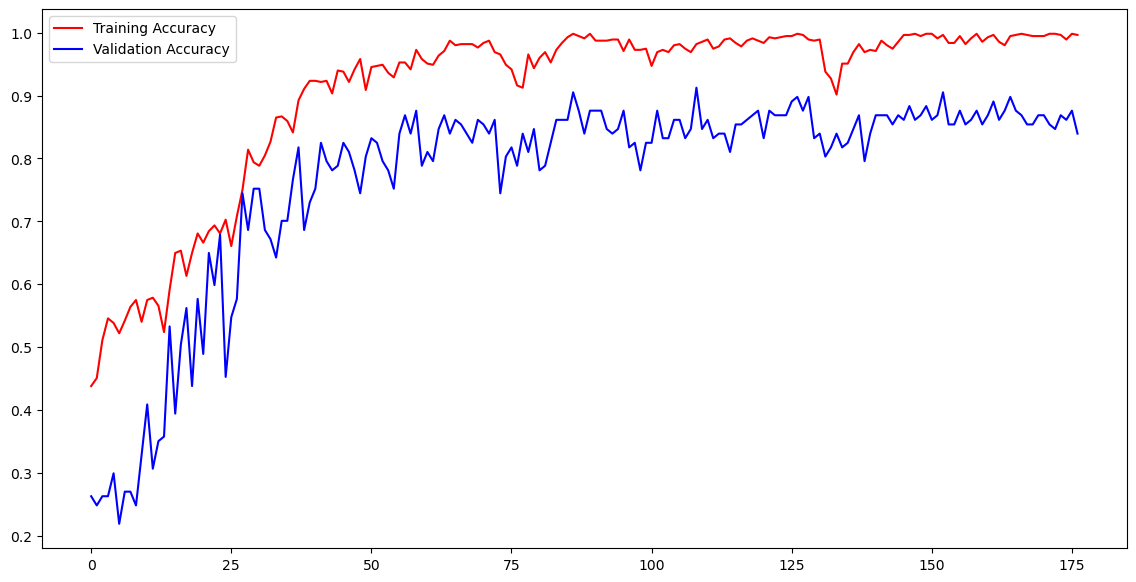

In [2]:
model.save('Brain_tumour_model.h5')
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()


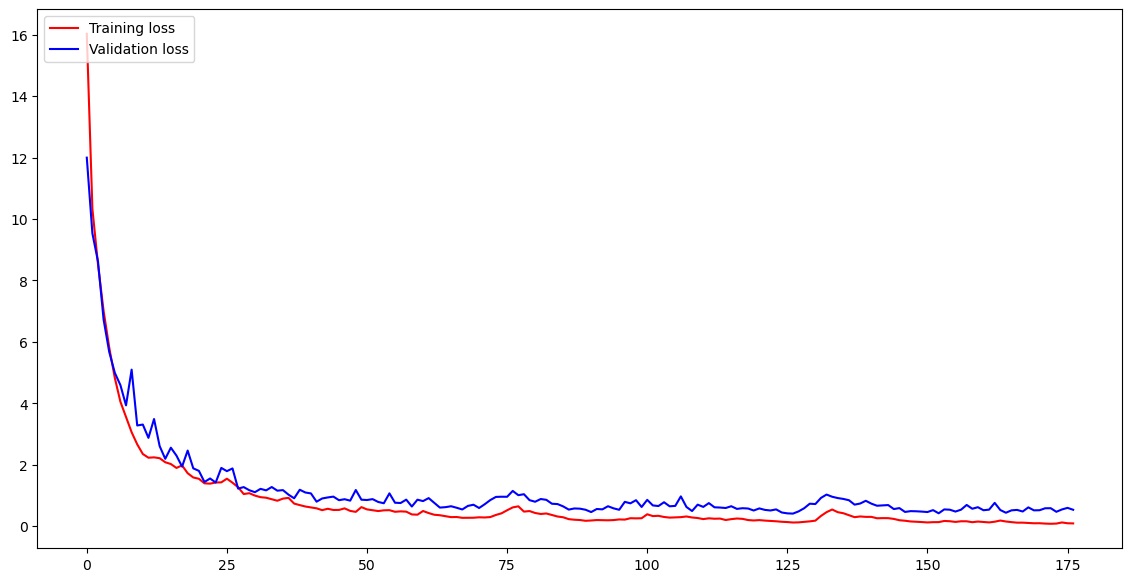

In [3]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [4]:
"""
import random
for i in range len(X_test)
    rand_idx = random.randrange(len(X_test))
    img = X_test[rand_idx]
    print(Y_test[rand_idx])
    img = np.array(img)
    img = img.reshape(1,128,128,3)
    img.shape
    prediction = model.predict(img)
    pred_val = prediction.argmax()
    pred_val
    """

'\nimport random\nfor i in range len(X_test)\n    rand_idx = random.randrange(len(X_test))\n    img = X_test[rand_idx]\n    print(Y_test[rand_idx])\n    img = np.array(img)\n    img = img.reshape(1,128,128,3)\n    img.shape\n    prediction = model.predict(img)\n    pred_val = prediction.argmax()\n    pred_val\n    '

In [5]:
def pred_name(n):
    print(classes_test[n])

In [6]:
realimg = '/kaggle/input/chest-ctscan-images/Data/test/normal/10 - Copy (2) - Copy.png'
img = cv2.imread(realimg)
img = cv2.resize(img,(256,256))
img =  np.array(img)
img = img.reshape(1,256,256,3)
prediction = model.predict(img)
pred_val = prediction.argmax()
n = pred_val.item()
pred_name(n)

1/1 [==============================] - 0s 211ms/step
normal
